## PRICE

### 1DCNN

Train windows: 87289, Validation windows: 8064, Test windows: 8352
First window ts: 2014-01-09 23:55:00, Last: 2024-12-24 23:55:00


/home/MAIN_USER/Desktop/Classical-Forecasting/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


No. of parameters: 8316832
Ep01 Train=0.0656 | Val=0.0051 | Val(last) RMSE=146951.8 MAE=121794.6 MAPE=187.21% R²=-191.536 | Val(full) RMSE=141719.3 MAE=114293.2 MAPE=186.48% | LR=0.000050 | Time=13.6s
Ep02 Train=0.0175 | Val=0.0008 | Val(last) RMSE=44809.4 MAE=35528.5 MAPE=167.33% R²=-16.902 | Val(full) RMSE=55307.2 MAE=43485.3 MAPE=170.77% | LR=0.000075 | Time=13.0s
Ep03 Train=0.0055 | Val=0.0003 | Val(last) RMSE=23579.2 MAE=17311.8 MAPE=158.46% R²=-3.957 | Val(full) RMSE=33052.5 MAE=25138.8 MAPE=170.74% | LR=0.000100 | Time=13.1s
Ep04 Train=0.0033 | Val=0.0001 | Val(last) RMSE=22593.5 MAE=17611.7 MAPE=131.86% R²=-3.551 | Val(full) RMSE=23956.7 MAE=17600.2 MAPE=139.69% | LR=0.000125 | Time=13.1s
Ep05 Train=0.0019 | Val=0.0002 | Val(last) RMSE=14661.9 MAE=8626.8 MAPE=114.68% R²=-0.917 | Val(full) RMSE=24277.3 MAE=17911.5 MAPE=127.82% | LR=0.000150 | Time=13.0s
Ep06 Train=0.0011 | Val=0.0001 | Val(last) RMSE=14369.7 MAE=8161.4 MAPE=122.39% R²=-0.841 | Val(full) RMSE=15902.0 MAE=9358.0 M

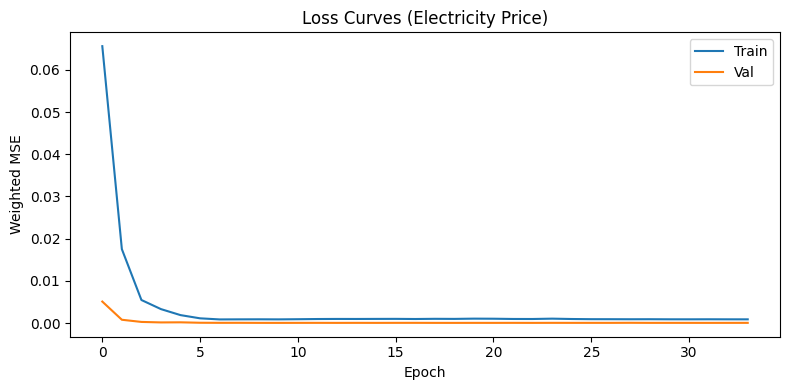

Test Loss (front-weighted MSE): 0.0000

Final Test Metrics (last step, currency units): MSE=127254128.00, RMSE=11280.70, MAE=5193.43, R²=-0.1371, Adj R²=-0.1411
Final Test Metrics (full 24h path): RMSE=11517.26, MAE=5644.09
Hourly-averaged RMSE by lead hour (0→23):
[10852.53, 10920.45, 10841.73, 10951.15, 11277.02, 11585.98, 12035.49,
 12127.02, 11661.41, 11352.82, 11222.33, 11218.66, 11171.67, 11177.52,
 11886.98, 12343.33, 11979.69, 11758.32, 11255.17, 11406.06, 11804.21,
 11902.95, 11947.99, 11525.38]
Avg inference latency: 0.20 ms/batch • 0.20 ms/sample


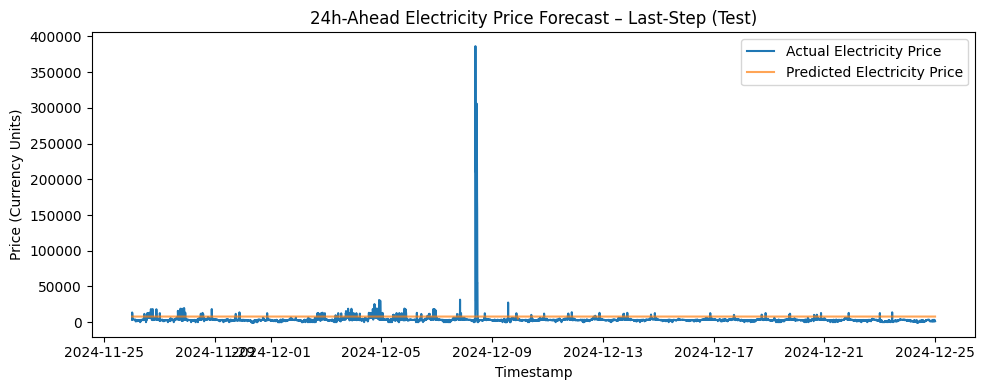

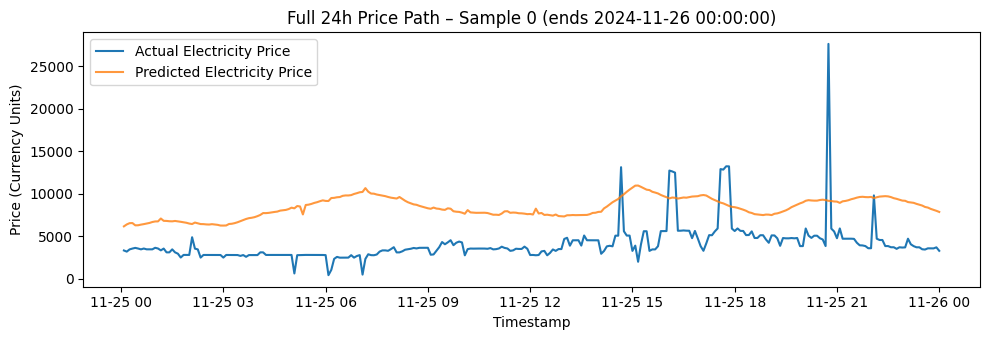

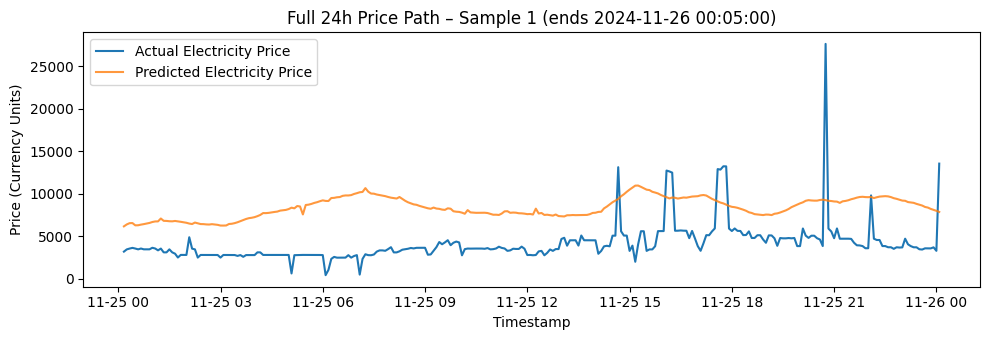

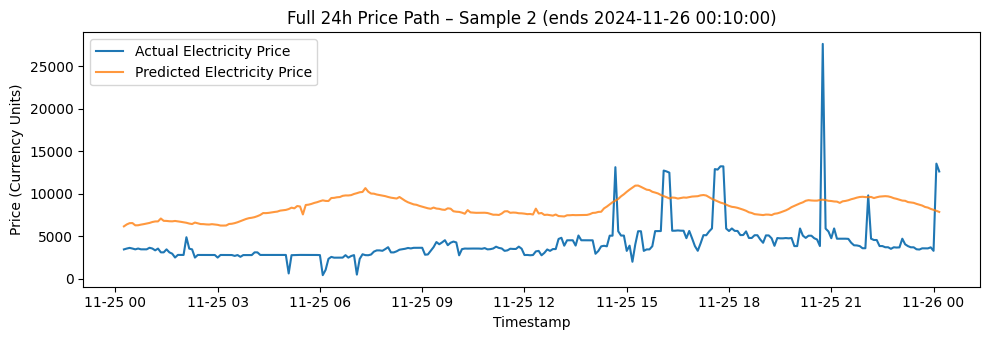

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model
# ----------------------------
class CNN1D_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 channels=32, ksize=9, pool=2, p_drop=0.1, hidden=64):
        super().__init__()
        pad = (ksize - 1) // 2
        self.conv = nn.Conv1d(n_features, channels, kernel_size=ksize, padding=pad, bias=True)
        self.pool = nn.AvgPool1d(pool)
        self.bn   = nn.BatchNorm1d(channels)
        self.do   = nn.Dropout(p_drop)

        conv_T = window // pool
        if conv_T <= 0:
            raise ValueError("Pooling/window configuration invalid; pooled length <= 0.")
        self.flat_dim = channels * conv_T

        concat_dim = self.flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon)
        )

    def forward(self, x):
        B, W, F = x.shape
        h = self.conv(x.permute(0, 2, 1))  # [B,C,W]
        h = self.pool(h)                   # [B,C,W/p]
        h = self.bn(h)
        h = self.do(h)
        h = h.reshape(B, -1)               # [B, C*(W/p)]
        z = torch.cat([h, x[:, -1, :]], dim=1)  # concat last-step features
        yhat = self.head(z)                     # [B,H]
        return yhat.unsqueeze(-1)               # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load electricity price dataset
    df = pd.read_csv('NASA-DATASET/price_forecasting.csv', parse_dates=['DATETIME'], index_col='DATETIME').fillna(0)
    df.index = pd.to_datetime(df.index, format='mixed', errors='raise')

    # Rename target variable for consistency with original code structure
    target_col = 'RTD_LMP_SMP'  # Electricity price target
    df['TARGET'] = df[target_col]

    # Handle missing values in target and available features
    available_cols = ['RTD_LMP_SMP', 'WS50M', 'ALLSKY_SFC_SW_DWN', 'T2M']
    for col in available_cols:
        if col in df.columns:
            df[col] = df[col].interpolate(method='time')
            df[col] = df[col].bfill().ffill()

    # Cadence sanity check
    _ = infer_5min_freq(df.index)

    # Window sizes for price forecasting
    W = 7 * 24 * 12   # one week lookback - prices have weekly patterns
    H = 1 * 24 * 12   # 24h horizon - 5 minute resolution

    # ----------------------------
    # Feature engineering (LEAK-FREE) - adapted for price data
    # ----------------------------
    steps_per_hour = 12
    steps_1h  = 1  * steps_per_hour       # 12
    steps_3h  = 3  * steps_per_hour       # 36
    steps_6h  = 6  * steps_per_hour       # 72
    steps_12h = 12 * steps_per_hour       # 144
    steps_24h = 24 * steps_per_hour       # 288

    # Seasonal lags for price patterns (daily and weekly cycles)
    season_lags = [288, 2016]  # 1 day and 1 week (7 * 24 * 12)
    for L in season_lags:
        if L < len(df):
            df[f'TARGET_lag{L}'] = df['TARGET'].shift(L)

    # Price-specific features: volatility and spike detection
    # Price volatility indicator
    win_1h = 1 * 12  # 1 hour
    price_rolling_std = df['TARGET'].rolling(win_1h, min_periods=win_1h//2).std()
    df['price_volatility'] = price_rolling_std.shift(1).fillna(0)

    # Price spike detection: unusually high prices
    price_rolling_mean = df['TARGET'].rolling(steps_24h, min_periods=steps_24h//2).mean()
    price_rolling_std_24h = df['TARGET'].rolling(steps_24h, min_periods=steps_24h//2).std()
    price_threshold = price_rolling_mean + 2 * price_rolling_std_24h
    df['price_spike'] = (df['TARGET'] > price_threshold).astype(int).shift(1).fillna(0)

    # Renewable generation impact on prices
    if 'ALLSKY_SFC_SW_DWN' in df.columns:
        # Solar generation proxy (daytime hours with solar irradiance)
        df['solar_impact'] = df['ALLSKY_SFC_SW_DWN'].shift(1).fillna(0)
        # Price-solar interaction (high solar = lower prices typically)
        df['price_solar_interaction'] = (df['TARGET'] * df['ALLSKY_SFC_SW_DWN']).shift(1).fillna(0)

    if 'WS50M' in df.columns:
        # Wind generation proxy
        df['wind_impact'] = df['WS50M'].shift(1).fillna(0)
        # Price-wind interaction
        df['price_wind_interaction'] = (df['TARGET'] * df['WS50M']).shift(1).fillna(0)

    # Temperature impact on prices (cooling/heating demand)
    if 'T2M' in df.columns:
        # Temperature deviation from comfort zone (around 22°C)
        comfort_temp = 22.0
        df['temp_deviation'] = np.abs(df['T2M'] - comfort_temp).shift(1).fillna(0)
        # Price-temperature interaction (extreme temps = higher demand = higher prices)
        df['price_temp_interaction'] = (df['TARGET'] * df['temp_deviation']).shift(1).fillna(0)

    # Rolling statistics on lagged target (past-only)
    target_shifted = df['TARGET'].shift(1)
    df['price_mean_1h']  = target_shifted.rolling(steps_1h,  min_periods=steps_1h//2).mean()
    df['price_std_1h']   = target_shifted.rolling(steps_1h,  min_periods=steps_1h//2).std()
    df['price_mean_3h']  = target_shifted.rolling(steps_3h,  min_periods=steps_3h//2).mean()
    df['price_std_3h']   = target_shifted.rolling(steps_3h,  min_periods=steps_3h//2).std()
    df['price_max_6h']   = target_shifted.rolling(steps_6h,  min_periods=steps_6h//2).max()
    df['price_min_6h']   = target_shifted.rolling(steps_6h,  min_periods=steps_6h//2).min()
    df['price_mean_12h'] = target_shifted.rolling(steps_12h, min_periods=steps_12h//2).mean()
    df['price_mean_24h'] = target_shifted.rolling(steps_24h, min_periods=steps_24h//2).mean()

    # Price momentum (rate of change) - past-only
    def safe_div(num, den, eps=1e-6):
        den = den.copy()
        den = den.where(den.abs() > eps, eps)
        return num / den

    m1_num = df['TARGET'].shift(1)
    m1_den_1h = df['TARGET'].shift(1 + steps_1h)
    m3_den_3h = df['TARGET'].shift(1 + steps_3h)
    m6_den_6h = df['TARGET'].shift(1 + steps_6h)

    df['price_momentum_1h'] = safe_div(m1_num, m1_den_1h) - 1.0
    df['price_momentum_3h'] = safe_div(m1_num, m3_den_3h) - 1.0
    df['price_momentum_6h'] = safe_div(m1_num, m6_den_6h) - 1.0
    df['price_momentum_1h'] = df['price_momentum_1h'].clip(-3, 3)
    df['price_momentum_3h'] = df['price_momentum_3h'].clip(-3, 3)
    df['price_momentum_6h'] = df['price_momentum_6h'].clip(-3, 3)

    # Peak/off-peak indicators
    hour = df.index.hour
    df['peak_hour'] = ((hour >= 6) & (hour <= 22)).astype(int)  # 6 AM to 10 PM
    df['super_peak'] = ((hour >= 16) & (hour <= 20)).astype(int)  # 4 PM to 8 PM
    df['weekend'] = (df.index.weekday >= 5).astype(int)  # Saturday = 5, Sunday = 6

    # Calendar features
    cal = make_calendar_features(df.index)

    # Available renewable/weather features
    renewable_cols = []
    if 'solar_impact' in df.columns:
        renewable_cols.extend(['solar_impact', 'price_solar_interaction'])
    if 'wind_impact' in df.columns:
        renewable_cols.extend(['wind_impact', 'price_wind_interaction'])
    if 'temp_deviation' in df.columns:
        renewable_cols.extend(['temp_deviation', 'price_temp_interaction'])

    # Price-specific engineered features
    price_eng_cols = ['price_volatility', 'price_spike', 'peak_hour', 'super_peak', 'weekend']

    # Assemble feature blocks
    lag_cols = [f'TARGET_lag{L}' for L in season_lags if f'TARGET_lag{L}' in df.columns]
    roll_cols = ['price_mean_1h', 'price_std_1h', 'price_mean_3h', 'price_std_3h',
                 'price_max_6h', 'price_min_6h', 'price_mean_12h', 'price_mean_24h']
    mom_cols = ['price_momentum_1h', 'price_momentum_3h', 'price_momentum_6h']

    feat_blocks = [cal]
    if renewable_cols:
        feat_blocks.append(df[renewable_cols])
    if lag_cols:
        feat_blocks.append(df[lag_cols])
    feat_blocks.append(df[price_eng_cols])
    feat_blocks.append(df[roll_cols + mom_cols])

    X_exo = pd.concat(feat_blocks, axis=1)

    # ----------------------------
    # Finite-only sanitization BEFORE scaling
    # ----------------------------
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps (each sample's last target time) AFTER filtering
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # ----------------------------
    # SCALING (leak-free)
    # ----------------------------
    train_mask_for_scaler = df.index <= train_end
    if not train_mask_for_scaler.any():
        # If no data before train_end, use first 70% for training
        n_train = int(0.7 * len(df))
        train_mask_for_scaler = df.index <= df.index[n_train]
        train_end = df.index[n_train]
        val_end = df.index[int(0.9 * len(df))]
        print(f"[INFO] Adjusted train_end to {train_end}, val_end to {val_end}")

    feat_scaler = MinMaxScaler()

    # Clean TRAIN slice for fit
    X_train = X_exo.loc[train_mask_for_scaler].copy()
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    good_train_rows = np.isfinite(X_train.to_numpy()).all(axis=1)
    X_train = X_train.loc[good_train_rows]

    if X_train.empty:
        raise ValueError("No finite rows remain in training features after sanitization.")

    feat_scaler.fit(X_train.to_numpy())

    # Clean FULL for transform
    X_full = X_exo.copy()
    X_full.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X_full.isna().any().any():
        X_full = X_full.bfill().ffill()

    keep_mask_full = np.isfinite(X_full.to_numpy()).all(axis=1)
    if not keep_mask_full.all():
        X_full = X_full.loc[keep_mask_full]
        df     = df.loc[X_full.index]
        times  = df.index[W + H - 1 :]

    X_feats_scaled = feat_scaler.transform(X_full.to_numpy())

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']].to_numpy())
    y_scaled = tgt_scaler.transform(df[['TARGET']].to_numpy())

    # Final data array: [features..., target_scaled] with target LAST
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # = F_feat + 1

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 12  # Moderate stride for price data
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN1D_Forecaster(
        n_features=n_features, window=W, horizon=H,
        channels=64, ksize=9, pool=2, p_drop=0.2, hidden=128
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for price forecasting (emphasize near-term accuracy for trading)
    weights = torch.linspace(2.0, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Electricity Price)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, currency units): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Electricity Price')
    plt.plot(times[test_idx], inv_p, label='Predicted Electricity Price', alpha=0.7)
    plt.title("24h-Ahead Electricity Price Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Price (Currency Units)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Electricity Price')
            plt.plot(tgrid, pred_i, label='Predicted Electricity Price', alpha=0.8)
            plt.title(f"Full 24h Price Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Price (Currency Units)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

### 2DCNN

/home/MAIN_USER/Desktop/Classical-Forecasting/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Train windows: 87289, Validation windows: 8064, Test windows: 8352
First window ts: 2014-01-09 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 256129376
Ep01 Train=0.2918 | Val=0.2463 | Val(last) RMSE=987471.1 MAE=987414.2 MAPE=200.00% R²=-8692.806 | Val(full) RMSE=987978.8 MAE=987908.2 MAPE=200.00% | LR=0.000050 | Time=431.2s
Ep02 Train=0.1867 | Val=0.1277 | Val(last) RMSE=711054.3 MAE=710975.5 MAPE=200.00% R²=-4506.822 | Val(full) RMSE=711522.1 MAE=711424.2 MAPE=200.00% | LR=0.000075 | Time=431.0s
Ep03 Train=0.0748 | Val=0.0307 | Val(last) RMSE=348230.6 MAE=348069.5 MAPE=200.00% R²=-1080.172 | Val(full) RMSE=348753.2 MAE=348554.1 MAPE=200.00% | LR=0.000100 | Time=438.5s
Ep04 Train=0.0112 | Val=0.0005 | Val(last) RMSE=42645.9 MAE=41310.0 MAPE=199.99% R²=-15.215 | Val(full) RMSE=43463.8 MAE=41835.4 MAPE=199.98% | LR=0.000125 | Time=441.1s
Ep05 Train=0.0013 | Val=0.0000 | Val(last) RMSE=12452.4 MAE=8007.5 MAPE=96.22% R²=-0.383 | Val(full) RMSE=13198.7 MAE=7931.4 MAPE=94.25% | LR=

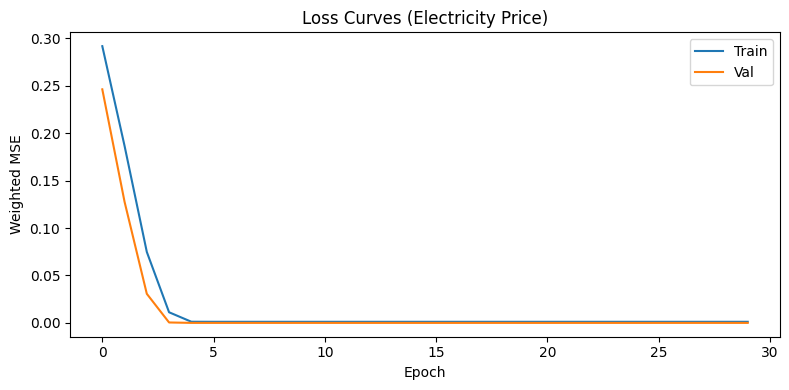

Test Loss (front-weighted MSE): 0.0000

Final Test Metrics (last step, currency units): MSE=173984240.00, RMSE=13190.31, MAE=8882.73, R²=-0.5546, Adj R²=-0.5602
Final Test Metrics (full 24h path): RMSE=13060.36, MAE=8664.99
Hourly-averaged RMSE by lead hour (0→23):
[13221.11, 13068.34, 13116.5 , 13169.06, 13307.15, 13258.39, 12835.77,
 12623.92, 12660.07, 12710.33, 12723.18, 12900.93, 12974.75, 13021.33,
 13040.24, 13053.34, 12902.14, 12821.06, 13010.85, 13084.27, 13256.13,
 13466.93, 13651.59, 13502.26]
Avg inference latency: 3.56 ms/batch • 3.56 ms/sample


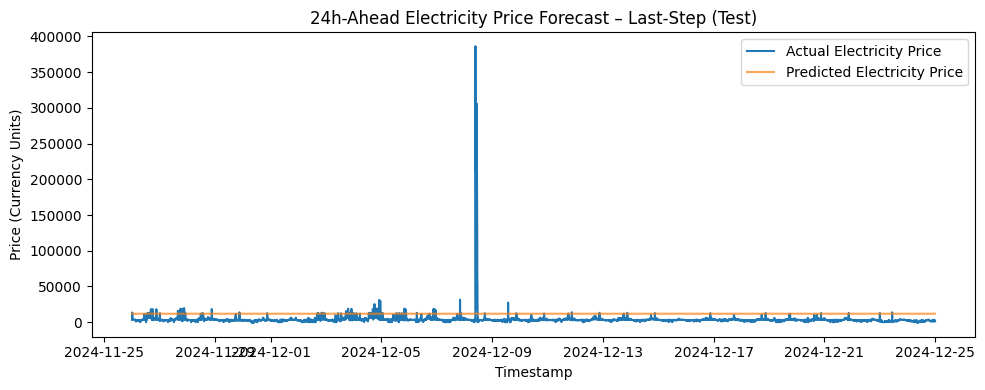

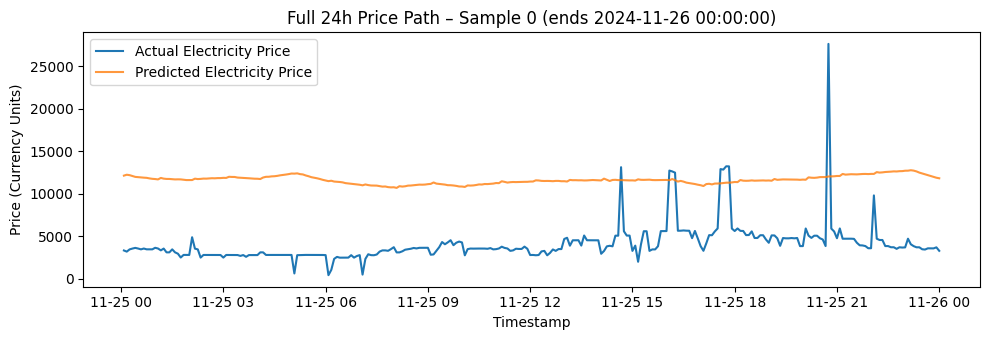

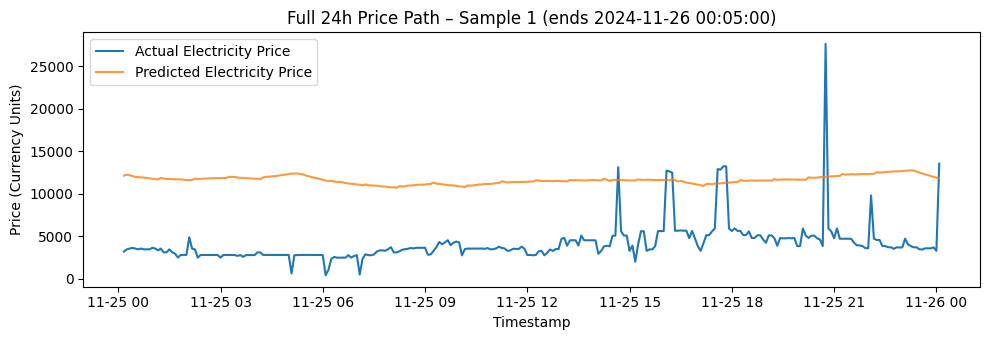

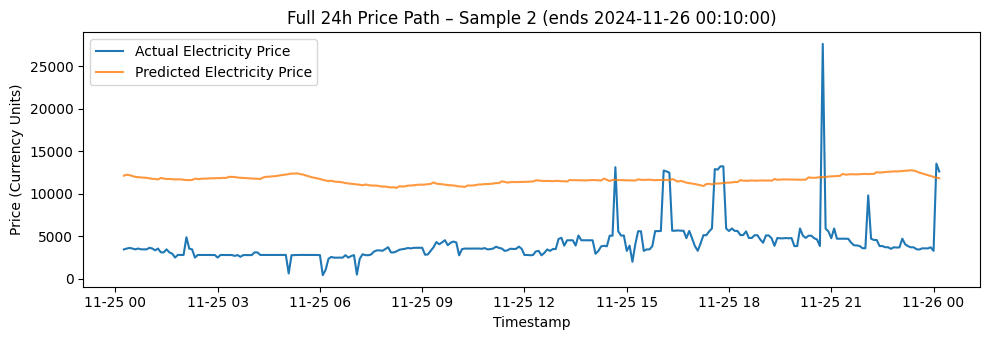

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model: 2D CNN forecaster (two Conv2d blocks)
# ----------------------------
class CNN2D_Forecaster(nn.Module):
    """
    Input [B, W, F]
      -> Unsqueeze -> [B,1,W,F]
      -> Conv2d(k_t1 x k_f1) + ReLU -> AvgPool2d(time only) -> BN -> Dropout
      -> Conv2d(k_t2 x k_f2) + ReLU -> AvgPool2d(time only) -> BN -> Dropout
      -> Flatten
      -> Concatenate with last-step raw features [B, F]
      -> MLP head -> horizon
      -> Output [B, H, 1]
    """
    def __init__(
        self,
        n_features: int,
        window: int,
        horizon: int,
        # block 1
        channels1: int = 64,
        ksize_t1: int = 9,
        ksize_f1: int = 3,
        pool_t1: int = 2,
        # block 2
        channels2: int = 64,
        ksize_t2: int = 5,
        ksize_f2: int = 3,
        pool_t2: int = 2,
        # head/regularization
        p_drop: float = 0.2,
        hidden: int = 256,
    ):
        super().__init__()
        if pool_t1 < 1 or pool_t2 < 1:
            raise ValueError("pool_t1 and pool_t2 must be >= 1")
        if (window // (pool_t1 * pool_t2)) <= 0:
            raise ValueError("window must be >= pool_t1 * pool_t2")

        self.n_features = n_features
        self.window = window
        self.horizon = horizon

        # -------- Block 1 --------
        pad_t1 = (ksize_t1 - 1) // 2
        pad_f1 = (ksize_f1 - 1) // 2
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=channels1,
            kernel_size=(ksize_t1, ksize_f1),
            padding=(pad_t1, pad_f1),
            bias=True,
        )
        self.act1  = nn.ReLU(inplace=True)
        self.pool1 = nn.AvgPool2d(kernel_size=(pool_t1, 1))  # downsample time only
        self.bn1   = nn.BatchNorm2d(channels1)
        self.do1   = nn.Dropout(p_drop)

        # -------- Block 2 --------
        pad_t2 = (ksize_t2 - 1) // 2
        pad_f2 = (ksize_f2 - 1) // 2
        self.conv2 = nn.Conv2d(
            in_channels=channels1,
            out_channels=channels2,
            kernel_size=(ksize_t2, ksize_f2),
            padding=(pad_t2, pad_f2),
            bias=True,
        )
        self.act2  = nn.ReLU(inplace=True)
        self.pool2 = nn.AvgPool2d(kernel_size=(pool_t2, 1))  # downsample time only
        self.bn2   = nn.BatchNorm2d(channels2)
        self.do2   = nn.Dropout(p_drop)

        # Flattened size after both pools
        conv_T = window // (pool_t1 * pool_t2)  # time length after two pools
        flat_dim = channels2 * conv_T * n_features

        # Head (concat flattened conv features with last-step raw features)
        concat_dim = flat_dim + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, hidden),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden, horizon),
        )

        # Init
        for m in [self.conv1, self.conv2]:
            nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, W, F]
        B, W, F = x.shape
        h = x.unsqueeze(1)      # [B,1,W,F]

        # Block 1
        h = self.conv1(h)
        h = self.act1(h)
        h = self.pool1(h)
        h = self.bn1(h)
        h = self.do1(h)

        # Block 2
        h = self.conv2(h)
        h = self.act2(h)
        h = self.pool2(h)
        h = self.bn2(h)
        h = self.do2(h)

        # Flatten
        h = h.reshape(B, -1)

        # Concatenate with last-step raw features
        x_last = x[:, -1, :]      # [B,F]
        z = torch.cat([h, x_last], dim=1)

        # Head
        yhat = self.head(z)       # [B,H]
        return yhat.unsqueeze(-1) # [B,H,1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load electricity price dataset
    df = pd.read_csv('NASA-DATASET/price_forecasting.csv', parse_dates=['DATETIME'], index_col='DATETIME').fillna(0)
    df.index = pd.to_datetime(df.index, format='mixed', errors='raise')

    # Rename target variable for consistency with original code structure
    target_col = 'RTD_LMP_SMP'  # Electricity price target
    df['TARGET'] = df[target_col]

    # Handle missing values in target and available features
    available_cols = ['RTD_LMP_SMP', 'WS50M', 'ALLSKY_SFC_SW_DWN', 'T2M']
    for col in available_cols:
        if col in df.columns:
            df[col] = df[col].interpolate(method='time')
            df[col] = df[col].bfill().ffill()

    # Cadence sanity check
    _ = infer_5min_freq(df.index)

    # Window sizes for price forecasting
    W = 7 * 24 * 12   # one week lookback - prices have weekly patterns
    H = 1 * 24 * 12   # 24h horizon - 5 minute resolution

    # ----------------------------
    # Feature engineering (LEAK-FREE) - adapted for price data
    # ----------------------------
    steps_per_hour = 12
    steps_1h  = 1  * steps_per_hour       # 12
    steps_3h  = 3  * steps_per_hour       # 36
    steps_6h  = 6  * steps_per_hour       # 72
    steps_12h = 12 * steps_per_hour       # 144
    steps_24h = 24 * steps_per_hour       # 288

    # Seasonal lags for price patterns (daily and weekly cycles)
    season_lags = [288, 2016]  # 1 day and 1 week (7 * 24 * 12)
    for L in season_lags:
        if L < len(df):
            df[f'TARGET_lag{L}'] = df['TARGET'].shift(L)

    # Price-specific features: volatility and spike detection
    # Price volatility indicator
    win_1h = 1 * 12  # 1 hour
    price_rolling_std = df['TARGET'].rolling(win_1h, min_periods=win_1h//2).std()
    df['price_volatility'] = price_rolling_std.shift(1).fillna(0)

    # Price spike detection: unusually high prices
    price_rolling_mean = df['TARGET'].rolling(steps_24h, min_periods=steps_24h//2).mean()
    price_rolling_std_24h = df['TARGET'].rolling(steps_24h, min_periods=steps_24h//2).std()
    price_threshold = price_rolling_mean + 2 * price_rolling_std_24h
    df['price_spike'] = (df['TARGET'] > price_threshold).astype(int).shift(1).fillna(0)

    # Renewable generation impact on prices
    if 'ALLSKY_SFC_SW_DWN' in df.columns:
        # Solar generation proxy (daytime hours with solar irradiance)
        df['solar_impact'] = df['ALLSKY_SFC_SW_DWN'].shift(1).fillna(0)
        # Price-solar interaction (high solar = lower prices typically)
        df['price_solar_interaction'] = (df['TARGET'] * df['ALLSKY_SFC_SW_DWN']).shift(1).fillna(0)

    if 'WS50M' in df.columns:
        # Wind generation proxy
        df['wind_impact'] = df['WS50M'].shift(1).fillna(0)
        # Price-wind interaction
        df['price_wind_interaction'] = (df['TARGET'] * df['WS50M']).shift(1).fillna(0)

    # Temperature impact on prices (cooling/heating demand)
    if 'T2M' in df.columns:
        # Temperature deviation from comfort zone (around 22°C)
        comfort_temp = 22.0
        df['temp_deviation'] = np.abs(df['T2M'] - comfort_temp).shift(1).fillna(0)
        # Price-temperature interaction (extreme temps = higher demand = higher prices)
        df['price_temp_interaction'] = (df['TARGET'] * df['temp_deviation']).shift(1).fillna(0)

    # Rolling statistics on lagged target (past-only)
    target_shifted = df['TARGET'].shift(1)
    df['price_mean_1h']  = target_shifted.rolling(steps_1h,  min_periods=steps_1h//2).mean()
    df['price_std_1h']   = target_shifted.rolling(steps_1h,  min_periods=steps_1h//2).std()
    df['price_mean_3h']  = target_shifted.rolling(steps_3h,  min_periods=steps_3h//2).mean()
    df['price_std_3h']   = target_shifted.rolling(steps_3h,  min_periods=steps_3h//2).std()
    df['price_max_6h']   = target_shifted.rolling(steps_6h,  min_periods=steps_6h//2).max()
    df['price_min_6h']   = target_shifted.rolling(steps_6h,  min_periods=steps_6h//2).min()
    df['price_mean_12h'] = target_shifted.rolling(steps_12h, min_periods=steps_12h//2).mean()
    df['price_mean_24h'] = target_shifted.rolling(steps_24h, min_periods=steps_24h//2).mean()

    # Price momentum (rate of change) - past-only
    def safe_div(num, den, eps=1e-6):
        den = den.copy()
        den = den.where(den.abs() > eps, eps)
        return num / den

    m1_num = df['TARGET'].shift(1)
    m1_den_1h = df['TARGET'].shift(1 + steps_1h)
    m3_den_3h = df['TARGET'].shift(1 + steps_3h)
    m6_den_6h = df['TARGET'].shift(1 + steps_6h)

    df['price_momentum_1h'] = safe_div(m1_num, m1_den_1h) - 1.0
    df['price_momentum_3h'] = safe_div(m1_num, m3_den_3h) - 1.0
    df['price_momentum_6h'] = safe_div(m1_num, m6_den_6h) - 1.0
    df['price_momentum_1h'] = df['price_momentum_1h'].clip(-3, 3)
    df['price_momentum_3h'] = df['price_momentum_3h'].clip(-3, 3)
    df['price_momentum_6h'] = df['price_momentum_6h'].clip(-3, 3)

    # Peak/off-peak indicators
    hour = df.index.hour
    df['peak_hour'] = ((hour >= 6) & (hour <= 22)).astype(int)  # 6 AM to 10 PM
    df['super_peak'] = ((hour >= 16) & (hour <= 20)).astype(int)  # 4 PM to 8 PM
    df['weekend'] = (df.index.weekday >= 5).astype(int)  # Saturday = 5, Sunday = 6

    # Calendar features
    cal = make_calendar_features(df.index)

    # Available renewable/weather features
    renewable_cols = []
    if 'solar_impact' in df.columns:
        renewable_cols.extend(['solar_impact', 'price_solar_interaction'])
    if 'wind_impact' in df.columns:
        renewable_cols.extend(['wind_impact', 'price_wind_interaction'])
    if 'temp_deviation' in df.columns:
        renewable_cols.extend(['temp_deviation', 'price_temp_interaction'])

    # Price-specific engineered features
    price_eng_cols = ['price_volatility', 'price_spike', 'peak_hour', 'super_peak', 'weekend']

    # Assemble feature blocks
    lag_cols = [f'TARGET_lag{L}' for L in season_lags if f'TARGET_lag{L}' in df.columns]
    roll_cols = ['price_mean_1h', 'price_std_1h', 'price_mean_3h', 'price_std_3h',
                 'price_max_6h', 'price_min_6h', 'price_mean_12h', 'price_mean_24h']
    mom_cols = ['price_momentum_1h', 'price_momentum_3h', 'price_momentum_6h']

    feat_blocks = [cal]
    if renewable_cols:
        feat_blocks.append(df[renewable_cols])
    if lag_cols:
        feat_blocks.append(df[lag_cols])
    feat_blocks.append(df[price_eng_cols])
    feat_blocks.append(df[roll_cols + mom_cols])

    X_exo = pd.concat(feat_blocks, axis=1)

    # ----------------------------
    # Finite-only sanitization BEFORE scaling
    # ----------------------------
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps (each sample's last target time) AFTER filtering
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # ----------------------------
    # SCALING (leak-free)
    # ----------------------------
    train_mask_for_scaler = df.index <= train_end
    if not train_mask_for_scaler.any():
        # If no data before train_end, use first 70% for training
        n_train = int(0.7 * len(df))
        train_mask_for_scaler = df.index <= df.index[n_train]
        train_end = df.index[n_train]
        val_end = df.index[int(0.9 * len(df))]
        print(f"[INFO] Adjusted train_end to {train_end}, val_end to {val_end}")

    feat_scaler = MinMaxScaler()

    # Clean TRAIN slice for fit
    X_train = X_exo.loc[train_mask_for_scaler].copy()
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    good_train_rows = np.isfinite(X_train.to_numpy()).all(axis=1)
    X_train = X_train.loc[good_train_rows]

    if X_train.empty:
        raise ValueError("No finite rows remain in training features after sanitization.")

    feat_scaler.fit(X_train.to_numpy())

    # Clean FULL for transform
    X_full = X_exo.copy()
    X_full.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X_full.isna().any().any():
        X_full = X_full.bfill().ffill()

    keep_mask_full = np.isfinite(X_full.to_numpy()).all(axis=1)
    if not keep_mask_full.all():
        X_full = X_full.loc[keep_mask_full]
        df     = df.loc[X_full.index]
        times  = df.index[W + H - 1 :]

    X_feats_scaled = feat_scaler.transform(X_full.to_numpy())

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']].to_numpy())
    y_scaled = tgt_scaler.transform(df[['TARGET']].to_numpy())

    # Final data array: [features..., target_scaled] with target LAST
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # = F_feat + 1

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 12  # Moderate stride for price data
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # 2D-CNN model + optimizer + loss + scheduler
    # ----------------------------
    model = CNN2D_Forecaster(
        n_features=n_features,
        window=W,
        horizon=H,
        channels1=64, ksize_t1=9, ksize_f1=3, pool_t1=2,
        channels2=64, ksize_t2=5, ksize_f2=3, pool_t2=2,
        p_drop=0.2, hidden=256
    ).to(device)

    # (Optional) tighter BN momentum for long sequences
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = 0.05

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for price forecasting (emphasize near-term accuracy for trading)
    weights = torch.linspace(2.0, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Electricity Price)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, currency units): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Electricity Price')
    plt.plot(times[test_idx], inv_p, label='Predicted Electricity Price', alpha=0.7)
    plt.title("24h-Ahead Electricity Price Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Price (Currency Units)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Electricity Price')
            plt.plot(tgrid, pred_i, label='Predicted Electricity Price', alpha=0.8)
            plt.title(f"Full 24h Price Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Price (Currency Units)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

### LSTM

Train windows: 87289, Validation windows: 8064, Test windows: 8352
First window ts: 2014-01-09 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 572321
Ep01 Train=0.0383 | Val=0.0009 | Val(last) RMSE=71140.2 MAE=56564.2 MAPE=173.97% R²=-44.122 | Val(full) RMSE=60807.4 MAE=47548.8 MAPE=174.24% | LR=0.000050 | Time=188.6s
Ep02 Train=0.0048 | Val=0.0002 | Val(last) RMSE=31694.1 MAE=23722.5 MAPE=151.89% R²=-7.956 | Val(full) RMSE=28026.2 MAE=20526.9 MAPE=146.85% | LR=0.000075 | Time=190.6s
Ep03 Train=0.0025 | Val=0.0001 | Val(last) RMSE=17125.9 MAE=10154.1 MAPE=124.39% R²=-1.615 | Val(full) RMSE=17810.7 MAE=11451.9 MAPE=120.66% | LR=0.000100 | Time=189.3s
Ep04 Train=0.0017 | Val=0.0001 | Val(last) RMSE=21522.0 MAE=18065.8 MAPE=131.06% R²=-3.130 | Val(full) RMSE=22779.0 MAE=18627.8 MAPE=127.85% | LR=0.000125 | Time=188.2s
Ep05 Train=0.0014 | Val=0.0001 | Val(last) RMSE=17897.3 MAE=13477.8 MAPE=115.78% R²=-1.856 | Val(full) RMSE=16628.1 MAE=10571.0 MAPE=101.45% | LR=0.000150 | Time=188.

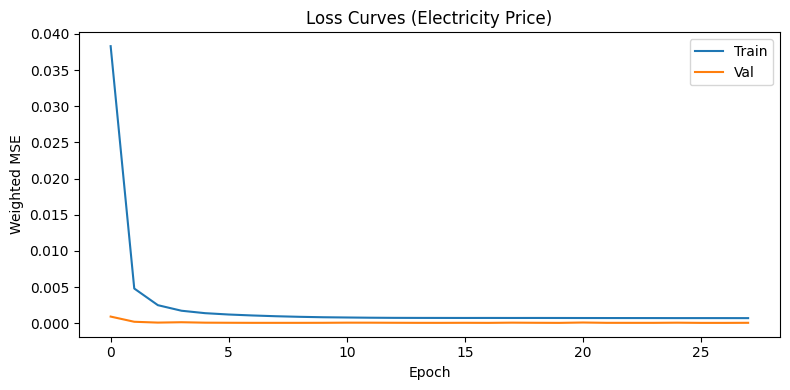

Test Loss (front-weighted MSE): 0.0001

Final Test Metrics (last step, currency units): MSE=259294064.00, RMSE=16102.61, MAE=9294.81, R²=-1.3169, Adj R²=-1.3252
Final Test Metrics (full 24h path): RMSE=16350.87, MAE=10115.72
Hourly-averaged RMSE by lead hour (0→23):
[14743.56, 15432.78, 14871.91, 15825.32, 17687.85, 18354.94, 17109.06,
 17447.19, 17379.61, 17517.16, 16105.51, 16682.7 , 16254.8 , 16846.74,
 15166.62, 16990.86, 15698.99, 15281.05, 15441.71, 16359.28, 15181.51,
 15805.78, 15409.51, 15512.2 ]
Avg inference latency: 18.37 ms/batch • 18.37 ms/sample


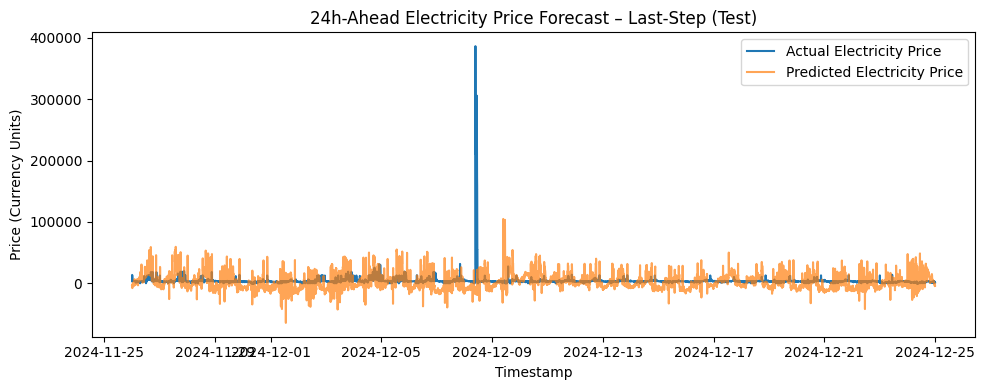

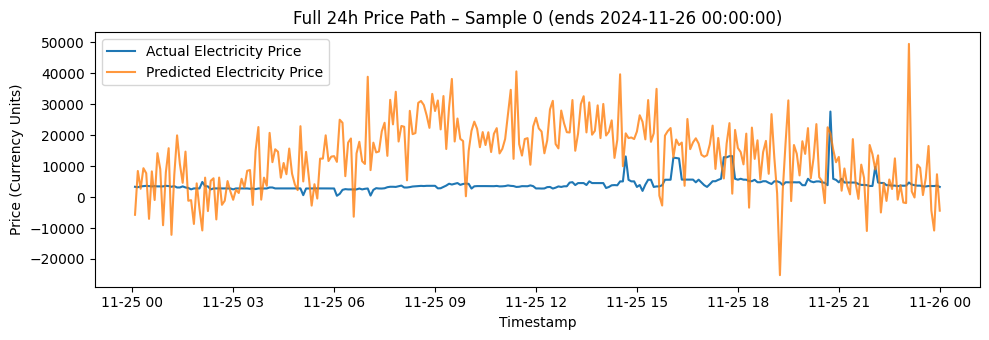

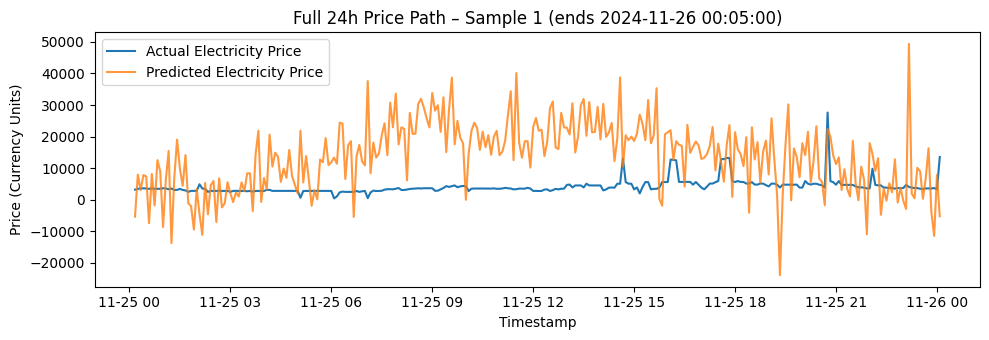

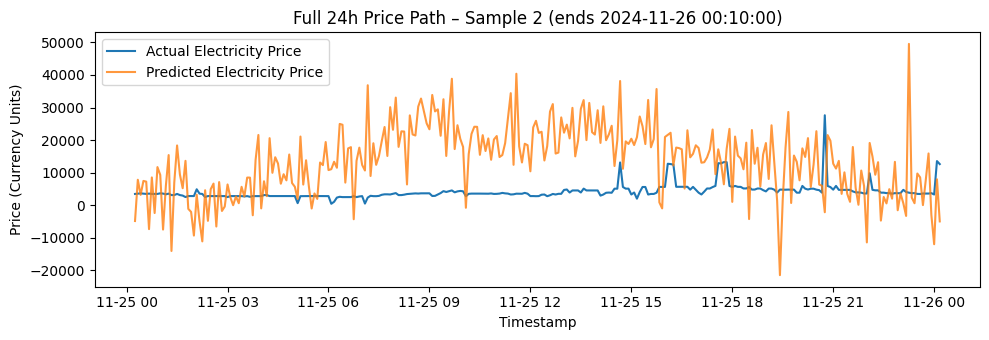

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# LSTM Model
# ----------------------------
class LSTM_Forecaster(nn.Module):
    def __init__(self, n_features, window, horizon,
                 enc1=256, enc2=128,
                 latent_dim=64, p_drop=0.2):
        super().__init__()
        self.n_features = n_features
        self.window = window
        self.horizon = horizon

        # Encoder
        self.enc1 = nn.LSTM(input_size=n_features, hidden_size=enc1, batch_first=True)
        self.enc2 = nn.LSTM(input_size=enc1,       hidden_size=enc2, batch_first=True)
        self.enc_ln = nn.LayerNorm(enc2)

        # Attention pooling over encoder sequence -> context
        self.attn = nn.Sequential(
            nn.Linear(enc2, enc2),
            nn.Tanh(),
            nn.Linear(enc2, 1)
        )

        # context -> latent
        self.to_latent = nn.Sequential(
            nn.Linear(enc2, latent_dim),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(latent_dim, latent_dim)
        )

        # Forecast head (TOTAL for H steps)
        # condition on [latent || last_observed_features] to anchor short-term
        f_in = latent_dim + n_features
        self.forecast = nn.Sequential(
            nn.Linear(f_in, 128),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(128, horizon)  # -> [B, H]
        )

    def forward(self, x):
        """
        x: [B, W, F]
        return: yhat [B, H, 1]  (forecast output)
        """
        B, W, F = x.shape

        # Encode
        h1, _ = self.enc1(x)               # [B,W,enc1]
        h2, _ = self.enc2(h1)              # [B,W,enc2]
        h2 = self.enc_ln(h2)

        # Attention pooling across time
        a = self.attn(h2)                  # [B,W,1]
        a = torch.softmax(a, dim=1)
        ctx = (a * h2).sum(dim=1)          # [B,enc2]

        # Latent
        z = self.to_latent(ctx)            # [B,latent]

        # Forecast
        x_last = x[:, -1, :]               # [B,F]
        f_in = torch.cat([z, x_last], dim=1)   # [B,latent+F]
        yhat = self.forecast(f_in).unsqueeze(-1)  # [B,H,1]
        return yhat

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load electricity price dataset
    df = pd.read_csv('NASA-DATASET/price_forecasting.csv', parse_dates=['DATETIME'], index_col='DATETIME').fillna(0)
    df.index = pd.to_datetime(df.index, format='mixed', errors='raise')

    # Rename target variable for consistency with original code structure
    target_col = 'RTD_LMP_SMP'  # Electricity price target
    df['TARGET'] = df[target_col]

    # Handle missing values in target and available features
    available_cols = ['RTD_LMP_SMP', 'WS50M', 'ALLSKY_SFC_SW_DWN', 'T2M']
    for col in available_cols:
        if col in df.columns:
            df[col] = df[col].interpolate(method='time')
            df[col] = df[col].bfill().ffill()

    # Cadence sanity check
    _ = infer_5min_freq(df.index)

    # Window sizes for price forecasting
    W = 7 * 24 * 12   # one week lookback - prices have weekly patterns
    H = 1 * 24 * 12   # 24h horizon - 5 minute resolution

    # ----------------------------
    # Feature engineering (LEAK-FREE) - adapted for price data
    # ----------------------------
    steps_per_hour = 12
    steps_1h  = 1  * steps_per_hour       # 12
    steps_3h  = 3  * steps_per_hour       # 36
    steps_6h  = 6  * steps_per_hour       # 72
    steps_12h = 12 * steps_per_hour       # 144
    steps_24h = 24 * steps_per_hour       # 288

    # Seasonal lags for price patterns (daily and weekly cycles)
    season_lags = [288, 2016]  # 1 day and 1 week (7 * 24 * 12)
    for L in season_lags:
        if L < len(df):
            df[f'TARGET_lag{L}'] = df['TARGET'].shift(L)

    # Price-specific features: volatility and spike detection
    # Price volatility indicator
    win_1h = 1 * 12  # 1 hour
    price_rolling_std = df['TARGET'].rolling(win_1h, min_periods=win_1h//2).std()
    df['price_volatility'] = price_rolling_std.shift(1).fillna(0)

    # Price spike detection: unusually high prices
    price_rolling_mean = df['TARGET'].rolling(steps_24h, min_periods=steps_24h//2).mean()
    price_rolling_std_24h = df['TARGET'].rolling(steps_24h, min_periods=steps_24h//2).std()
    price_threshold = price_rolling_mean + 2 * price_rolling_std_24h
    df['price_spike'] = (df['TARGET'] > price_threshold).astype(int).shift(1).fillna(0)

    # Renewable generation impact on prices
    if 'ALLSKY_SFC_SW_DWN' in df.columns:
        # Solar generation proxy (daytime hours with solar irradiance)
        df['solar_impact'] = df['ALLSKY_SFC_SW_DWN'].shift(1).fillna(0)
        # Price-solar interaction (high solar = lower prices typically)
        df['price_solar_interaction'] = (df['TARGET'] * df['ALLSKY_SFC_SW_DWN']).shift(1).fillna(0)

    if 'WS50M' in df.columns:
        # Wind generation proxy
        df['wind_impact'] = df['WS50M'].shift(1).fillna(0)
        # Price-wind interaction
        df['price_wind_interaction'] = (df['TARGET'] * df['WS50M']).shift(1).fillna(0)

    # Temperature impact on prices (cooling/heating demand)
    if 'T2M' in df.columns:
        # Temperature deviation from comfort zone (around 22°C)
        comfort_temp = 22.0
        df['temp_deviation'] = np.abs(df['T2M'] - comfort_temp).shift(1).fillna(0)
        # Price-temperature interaction (extreme temps = higher demand = higher prices)
        df['price_temp_interaction'] = (df['TARGET'] * df['temp_deviation']).shift(1).fillna(0)

    # Rolling statistics on lagged target (past-only)
    target_shifted = df['TARGET'].shift(1)
    df['price_mean_1h']  = target_shifted.rolling(steps_1h,  min_periods=steps_1h//2).mean()
    df['price_std_1h']   = target_shifted.rolling(steps_1h,  min_periods=steps_1h//2).std()
    df['price_mean_3h']  = target_shifted.rolling(steps_3h,  min_periods=steps_3h//2).mean()
    df['price_std_3h']   = target_shifted.rolling(steps_3h,  min_periods=steps_3h//2).std()
    df['price_max_6h']   = target_shifted.rolling(steps_6h,  min_periods=steps_6h//2).max()
    df['price_min_6h']   = target_shifted.rolling(steps_6h,  min_periods=steps_6h//2).min()
    df['price_mean_12h'] = target_shifted.rolling(steps_12h, min_periods=steps_12h//2).mean()
    df['price_mean_24h'] = target_shifted.rolling(steps_24h, min_periods=steps_24h//2).mean()

    # Price momentum (rate of change) - past-only
    def safe_div(num, den, eps=1e-6):
        den = den.copy()
        den = den.where(den.abs() > eps, eps)
        return num / den

    m1_num = df['TARGET'].shift(1)
    m1_den_1h = df['TARGET'].shift(1 + steps_1h)
    m3_den_3h = df['TARGET'].shift(1 + steps_3h)
    m6_den_6h = df['TARGET'].shift(1 + steps_6h)

    df['price_momentum_1h'] = safe_div(m1_num, m1_den_1h) - 1.0
    df['price_momentum_3h'] = safe_div(m1_num, m3_den_3h) - 1.0
    df['price_momentum_6h'] = safe_div(m1_num, m6_den_6h) - 1.0
    df['price_momentum_1h'] = df['price_momentum_1h'].clip(-3, 3)
    df['price_momentum_3h'] = df['price_momentum_3h'].clip(-3, 3)
    df['price_momentum_6h'] = df['price_momentum_6h'].clip(-3, 3)

    # Peak/off-peak indicators
    hour = df.index.hour
    df['peak_hour'] = ((hour >= 6) & (hour <= 22)).astype(int)  # 6 AM to 10 PM
    df['super_peak'] = ((hour >= 16) & (hour <= 20)).astype(int)  # 4 PM to 8 PM
    df['weekend'] = (df.index.weekday >= 5).astype(int)  # Saturday = 5, Sunday = 6

    # Calendar features
    cal = make_calendar_features(df.index)

    # Available renewable/weather features
    renewable_cols = []
    if 'solar_impact' in df.columns:
        renewable_cols.extend(['solar_impact', 'price_solar_interaction'])
    if 'wind_impact' in df.columns:
        renewable_cols.extend(['wind_impact', 'price_wind_interaction'])
    if 'temp_deviation' in df.columns:
        renewable_cols.extend(['temp_deviation', 'price_temp_interaction'])

    # Price-specific engineered features
    price_eng_cols = ['price_volatility', 'price_spike', 'peak_hour', 'super_peak', 'weekend']

    # Assemble feature blocks
    lag_cols = [f'TARGET_lag{L}' for L in season_lags if f'TARGET_lag{L}' in df.columns]
    roll_cols = ['price_mean_1h', 'price_std_1h', 'price_mean_3h', 'price_std_3h',
                 'price_max_6h', 'price_min_6h', 'price_mean_12h', 'price_mean_24h']
    mom_cols = ['price_momentum_1h', 'price_momentum_3h', 'price_momentum_6h']

    feat_blocks = [cal]
    if renewable_cols:
        feat_blocks.append(df[renewable_cols])
    if lag_cols:
        feat_blocks.append(df[lag_cols])
    feat_blocks.append(df[price_eng_cols])
    feat_blocks.append(df[roll_cols + mom_cols])

    X_exo = pd.concat(feat_blocks, axis=1)

    # ----------------------------
    # Finite-only sanitization BEFORE scaling
    # ----------------------------
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps (each sample's last target time) AFTER filtering
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # ----------------------------
    # SCALING (leak-free)
    # ----------------------------
    train_mask_for_scaler = df.index <= train_end
    if not train_mask_for_scaler.any():
        # If no data before train_end, use first 70% for training
        n_train = int(0.7 * len(df))
        train_mask_for_scaler = df.index <= df.index[n_train]
        train_end = df.index[n_train]
        val_end = df.index[int(0.9 * len(df))]
        print(f"[INFO] Adjusted train_end to {train_end}, val_end to {val_end}")

    feat_scaler = MinMaxScaler()

    # Clean TRAIN slice for fit
    X_train = X_exo.loc[train_mask_for_scaler].copy()
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    good_train_rows = np.isfinite(X_train.to_numpy()).all(axis=1)
    X_train = X_train.loc[good_train_rows]

    if X_train.empty:
        raise ValueError("No finite rows remain in training features after sanitization.")

    feat_scaler.fit(X_train.to_numpy())

    # Clean FULL for transform
    X_full = X_exo.copy()
    X_full.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X_full.isna().any().any():
        X_full = X_full.bfill().ffill()

    keep_mask_full = np.isfinite(X_full.to_numpy()).all(axis=1)
    if not keep_mask_full.all():
        X_full = X_full.loc[keep_mask_full]
        df     = df.loc[X_full.index]
        times  = df.index[W + H - 1 :]

    X_feats_scaled = feat_scaler.transform(X_full.to_numpy())

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']].to_numpy())
    y_scaled = tgt_scaler.transform(df[['TARGET']].to_numpy())

    # Final data array: [features..., target_scaled] with target LAST
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # = F_feat + 1

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 12  # Moderate stride for price data
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # LSTM model
    # ----------------------------
    model = LSTM_Forecaster(n_features=n_features, window=W, horizon=H,
        enc1=256, enc2=128, latent_dim=64, p_drop=0.2
        ).to(device)

    # (Optional) tighter BN momentum for long sequences
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.momentum = 0.05

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for price forecasting (emphasize near-term accuracy for trading)
    weights = torch.linspace(2.0, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Electricity Price)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, currency units): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Electricity Price')
    plt.plot(times[test_idx], inv_p, label='Predicted Electricity Price', alpha=0.7)
    plt.title("24h-Ahead Electricity Price Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Price (Currency Units)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Electricity Price')
            plt.plot(tgrid, pred_i, label='Predicted Electricity Price', alpha=0.8)
            plt.title(f"Full 24h Price Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Price (Currency Units)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()

### TRANSFORMER

Train windows: 87289, Validation windows: 8064, Test windows: 8352
First window ts: 2014-01-09 23:55:00, Last: 2024-12-24 23:55:00
No. of parameters: 649248


/home/MAIN_USER/Desktop/Classical-Forecasting/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Ep01 Train=0.0229 | Val=0.0007 | Val(last) RMSE=46499.4 MAE=37073.7 MAPE=161.47% R²=-18.278 | Val(full) RMSE=54546.2 MAE=42705.6 MAPE=161.49% | LR=0.000050 | Time=1953.0s
Ep02 Train=0.0029 | Val=0.0002 | Val(last) RMSE=25833.9 MAE=19527.7 MAPE=171.48% R²=-4.950 | Val(full) RMSE=28848.6 MAE=21453.4 MAPE=154.13% | LR=0.000075 | Time=1990.7s
Ep03 Train=0.0017 | Val=0.0002 | Val(last) RMSE=32001.2 MAE=28699.6 MAPE=197.70% R²=-8.130 | Val(full) RMSE=29599.0 MAE=23336.6 MAPE=177.89% | LR=0.000100 | Time=1925.7s
Ep04 Train=0.0013 | Val=0.0001 | Val(last) RMSE=35190.8 MAE=32714.8 MAPE=199.28% R²=-10.041 | Val(full) RMSE=20939.2 MAE=14730.9 MAPE=153.06% | LR=0.000125 | Time=1923.8s
Ep05 Train=0.0012 | Val=0.0002 | Val(last) RMSE=29132.8 MAE=26241.1 MAPE=197.72% R²=-6.567 | Val(full) RMSE=24792.6 MAE=19269.5 MAPE=174.53% | LR=0.000150 | Time=1923.7s
Ep06 Train=0.0010 | Val=0.0002 | Val(last) RMSE=28123.9 MAE=25364.9 MAPE=198.62% R²=-6.052 | Val(full) RMSE=25422.0 MAE=20061.8 MAPE=180.13% | LR=0.

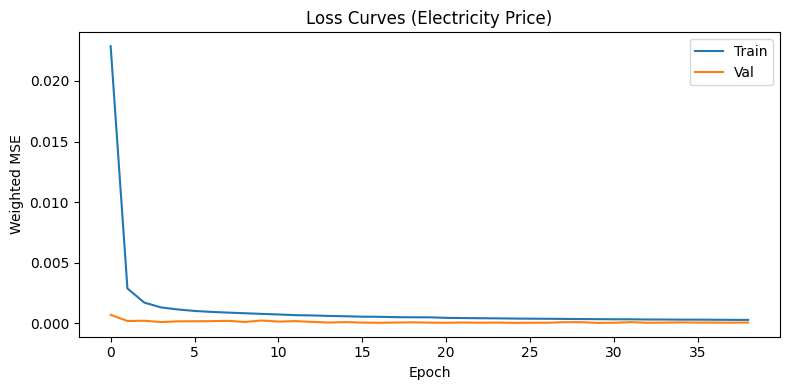

Test Loss (front-weighted MSE): 0.0001

Final Test Metrics (last step, currency units): MSE=299063584.00, RMSE=17293.46, MAE=13229.00, R²=-1.6722, Adj R²=-1.6818
Final Test Metrics (full 24h path): RMSE=15777.26, MAE=10153.10
Hourly-averaged RMSE by lead hour (0→23):
[16759.95, 14839.15, 13397.99, 12728.77, 13459.21, 12167.97, 12835.75,
 19139.3 , 18829.69, 17699.27, 17401.72, 16728.01, 21603.62, 20769.21,
 19163.85, 15578.2 , 12038.99, 11816.76, 11679.62, 11601.22, 12270.12,
 12711.25, 16308.97, 18164.39]
Avg inference latency: 5.66 ms/batch • 5.66 ms/sample


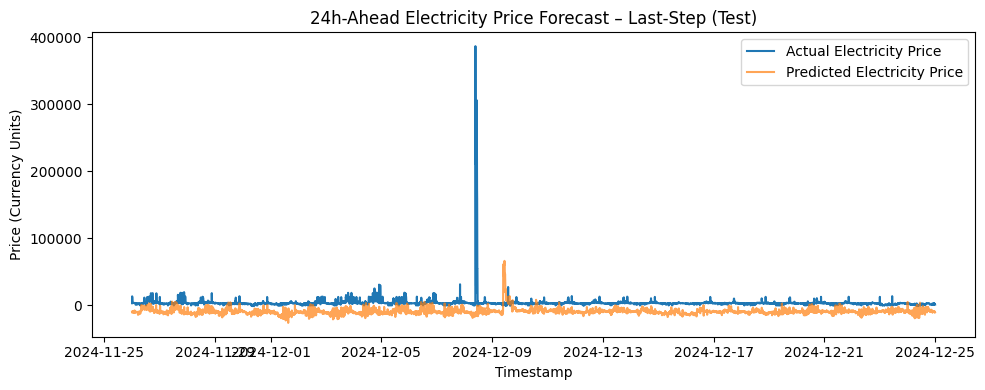

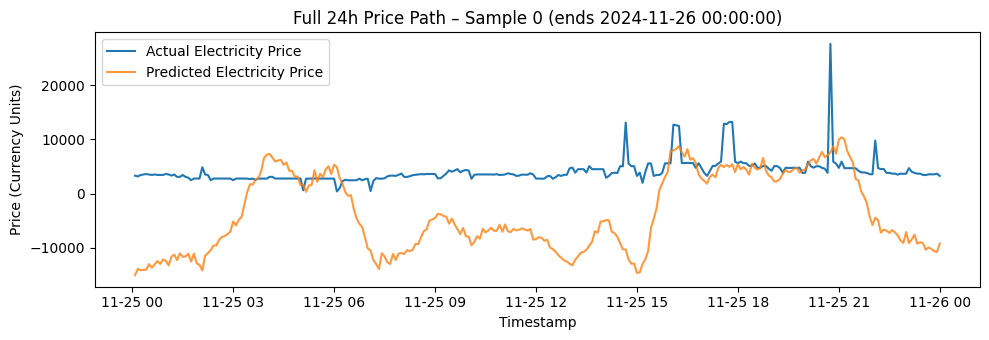

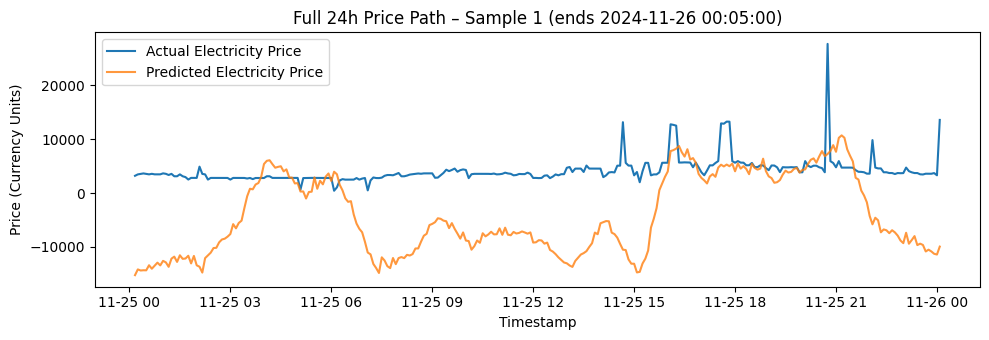

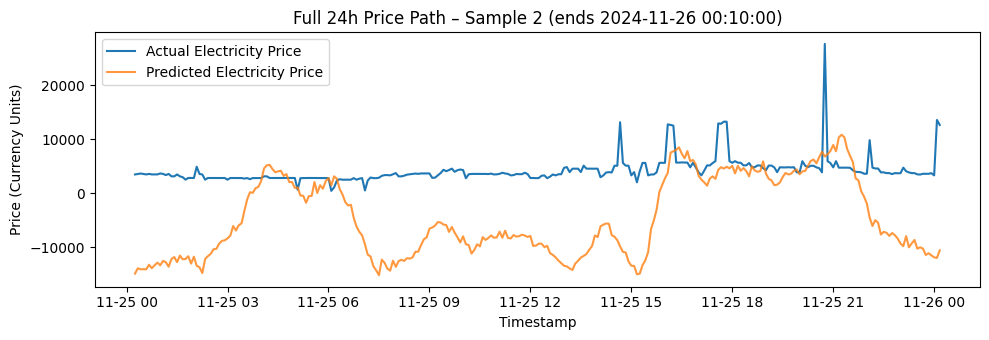

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time, random, math
from typing import List
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------------------
# Reproducibility
# ----------------------------
def set_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1337)

# ----------------------------
# Dataset
# ----------------------------
class LoadWindowDataset(Dataset):
    def __init__(self, data_array, window, horizon):
        self.data = data_array
        self.window, self.horizon = window, horizon
        self.n = data_array.shape[0] - window - horizon + 1
        if self.n <= 0:
            raise ValueError("Window/horizon too large for data length.")

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        x = self.data[idx: idx + self.window]                                        # [W, F]
        y_seq = self.data[idx + self.window: idx + self.window + self.horizon, -1:] # [H, 1]
        return torch.from_numpy(x).float(), torch.from_numpy(y_seq).float()

# ----------------------------
# Model: Transformer forecaster
# ----------------------------
class PositionalEncoding(nn.Module):
    """Standard sinusoidal PE (batch_first: [B, T, D])."""
    def __init__(self, d_model: int, max_len: int = 10000, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)  # [T, D]
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)  # [T, 1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # even
        pe[:, 1::2] = torch.cos(position * div_term)  # odd
        pe = pe.unsqueeze(0)  # [1, T, D]
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, T, D]
        T = x.size(1)
        x = x + self.pe[:, :T, :]
        return self.dropout(x)

class TransformerForecaster(nn.Module):
    """
    Encoder-only Transformer:
      - Input: [B, W, F]
      - Linear embed: F -> d_model
      - Add positional encodings
      - TransformerEncoder (batch_first)
      - Temporal mean pool -> [B, d_model]
      - Concatenate with raw last-step features [B, F]
      - MLP head -> horizon
      - Output: [B, H, 1]
    """
    def __init__(
        self,
        n_features: int,
        window: int,
        horizon: int,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dim_feedforward: int = 256,
        p_drop: float = 0.1
    ):
        super().__init__()
        assert d_model % nhead == 0, "d_model must be divisible by nhead"
        self.n_features = n_features
        self.window = window
        self.horizon = horizon
        self.d_model = d_model

        self.input_proj = nn.Linear(n_features, d_model)
        self.pos_enc = PositionalEncoding(d_model=d_model, max_len=window, dropout=p_drop)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=p_drop,
            batch_first=True,
            activation='gelu',
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.enc_ln = nn.LayerNorm(d_model)

        # Head after pooling + concat(last-step raw features)
        concat_dim = d_model + n_features
        self.head = nn.Sequential(
            nn.Linear(concat_dim, 2 * d_model),
            nn.GELU(),
            nn.Dropout(p_drop),
            nn.Linear(2 * d_model, horizon)
        )

        # Initialize
        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.input_proj.weight)
        nn.init.zeros_(self.input_proj.bias)
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, W, F]
        B, W, F = x.shape
        h = self.input_proj(x)            # [B, W, D]
        h = self.pos_enc(h)               # [B, W, D]
        h = self.encoder(h)               # [B, W, D]
        h = self.enc_ln(h)

        # Temporal mean pooling
        h_pool = h.mean(dim=1)            # [B, D]

        # Skip: last-step raw features
        x_last = x[:, -1, :]              # [B, F]
        z = torch.cat([h_pool, x_last], dim=1)  # [B, D+F]

        yhat = self.head(z)               # [B, H]
        return yhat.unsqueeze(-1)         # [B, H, 1]

# ----------------------------
# Early Stopping (CPU snapshot)
# ----------------------------
class EarlyStopping:
    def __init__(self, patience=25, delta=1e-4, verbose=True):
        self.patience, self.delta, self.verbose = patience, delta, verbose
        self.best_loss = np.inf
        self.wait = 0
        self.should_stop = False
        self.best_state = None

    def step(self, val_loss, model=None):
        improved = val_loss < self.best_loss - self.delta
        if improved:
            self.best_loss = val_loss
            self.wait = 0
            if model is not None:
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.should_stop = True
                if self.verbose:
                    print(f"EarlyStopping: stop after {self.patience} epochs.")
        return improved

# ----------------------------
# Helpers
# ----------------------------
def infer_5min_freq(index: pd.DatetimeIndex) -> pd.Timedelta:
    freq = pd.infer_freq(index)
    if freq is None:
        diffs = pd.Series(index[1:] - index[:-1])
        step = diffs.mode().iloc[0] if not diffs.empty else pd.Timedelta(minutes=5)
    else:
        step = pd.Timedelta(freq)
    if step != pd.Timedelta(minutes=5):
        print(f"[WARN] Detected step={step}. Script assumes 5-minute cadence.")
    return step

def make_calendar_features(idx: pd.DatetimeIndex) -> pd.DataFrame:
    hour = idx.hour + idx.minute/60.0
    hod = hour / 24.0
    dow = idx.dayofweek.astype(float) / 7.0
    doy = (idx.dayofyear.astype(float) - 1.0) / 366.0
    cal = pd.DataFrame(index=idx)
    cal["hod_sin"] = np.sin(2*np.pi*hod); cal["hod_cos"] = np.cos(2*np.pi*hod)
    cal["dow_sin"] = np.sin(2*np.pi*dow); cal["dow_cos"] = np.cos(2*np.pi*dow)
    cal["doy_sin"] = np.sin(2*np.pi*doy); cal["doy_cos"] = np.cos(2*np.pi*doy)
    return cal

def cosine_warmup_scheduler(optimizer, warmup_epochs, total_epochs):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / float(warmup_epochs)
        denom = max(float(total_epochs - warmup_epochs), 1.0)
        progress = min(max((epoch - warmup_epochs) / denom, 0.0), 1.0)
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)
    )

# ----------------------------
# Main
# ----------------------------
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load electricity price dataset
    df = pd.read_csv('NASA-DATASET/price_forecasting.csv', parse_dates=['DATETIME'], index_col='DATETIME').fillna(0)
    df.index = pd.to_datetime(df.index, format='mixed', errors='raise')

    # Rename target variable for consistency with original code structure
    target_col = 'RTD_LMP_SMP'  # Electricity price target
    df['TARGET'] = df[target_col]

    # Handle missing values in target and available features
    available_cols = ['RTD_LMP_SMP', 'WS50M', 'ALLSKY_SFC_SW_DWN', 'T2M']
    for col in available_cols:
        if col in df.columns:
            df[col] = df[col].interpolate(method='time')
            df[col] = df[col].bfill().ffill()

    # Cadence sanity check
    _ = infer_5min_freq(df.index)

    # Window sizes for price forecasting
    W = 7 * 24 * 12   # one week lookback - prices have weekly patterns
    H = 1 * 24 * 12   # 24h horizon - 5 minute resolution

    # ----------------------------
    # Feature engineering (LEAK-FREE) - adapted for price data
    # ----------------------------
    steps_per_hour = 12
    steps_1h  = 1  * steps_per_hour       # 12
    steps_3h  = 3  * steps_per_hour       # 36
    steps_6h  = 6  * steps_per_hour       # 72
    steps_12h = 12 * steps_per_hour       # 144
    steps_24h = 24 * steps_per_hour       # 288

    # Seasonal lags for price patterns (daily and weekly cycles)
    season_lags = [288, 2016]  # 1 day and 1 week (7 * 24 * 12)
    for L in season_lags:
        if L < len(df):
            df[f'TARGET_lag{L}'] = df['TARGET'].shift(L)

    # Price-specific features: volatility and spike detection
    # Price volatility indicator
    win_1h = 1 * 12  # 1 hour
    price_rolling_std = df['TARGET'].rolling(win_1h, min_periods=win_1h//2).std()
    df['price_volatility'] = price_rolling_std.shift(1).fillna(0)

    # Price spike detection: unusually high prices
    price_rolling_mean = df['TARGET'].rolling(steps_24h, min_periods=steps_24h//2).mean()
    price_rolling_std_24h = df['TARGET'].rolling(steps_24h, min_periods=steps_24h//2).std()
    price_threshold = price_rolling_mean + 2 * price_rolling_std_24h
    df['price_spike'] = (df['TARGET'] > price_threshold).astype(int).shift(1).fillna(0)

    # Renewable generation impact on prices
    if 'ALLSKY_SFC_SW_DWN' in df.columns:
        # Solar generation proxy (daytime hours with solar irradiance)
        df['solar_impact'] = df['ALLSKY_SFC_SW_DWN'].shift(1).fillna(0)
        # Price-solar interaction (high solar = lower prices typically)
        df['price_solar_interaction'] = (df['TARGET'] * df['ALLSKY_SFC_SW_DWN']).shift(1).fillna(0)

    if 'WS50M' in df.columns:
        # Wind generation proxy
        df['wind_impact'] = df['WS50M'].shift(1).fillna(0)
        # Price-wind interaction
        df['price_wind_interaction'] = (df['TARGET'] * df['WS50M']).shift(1).fillna(0)

    # Temperature impact on prices (cooling/heating demand)
    if 'T2M' in df.columns:
        # Temperature deviation from comfort zone (around 22°C)
        comfort_temp = 22.0
        df['temp_deviation'] = np.abs(df['T2M'] - comfort_temp).shift(1).fillna(0)
        # Price-temperature interaction (extreme temps = higher demand = higher prices)
        df['price_temp_interaction'] = (df['TARGET'] * df['temp_deviation']).shift(1).fillna(0)

    # Rolling statistics on lagged target (past-only)
    target_shifted = df['TARGET'].shift(1)
    df['price_mean_1h']  = target_shifted.rolling(steps_1h,  min_periods=steps_1h//2).mean()
    df['price_std_1h']   = target_shifted.rolling(steps_1h,  min_periods=steps_1h//2).std()
    df['price_mean_3h']  = target_shifted.rolling(steps_3h,  min_periods=steps_3h//2).mean()
    df['price_std_3h']   = target_shifted.rolling(steps_3h,  min_periods=steps_3h//2).std()
    df['price_max_6h']   = target_shifted.rolling(steps_6h,  min_periods=steps_6h//2).max()
    df['price_min_6h']   = target_shifted.rolling(steps_6h,  min_periods=steps_6h//2).min()
    df['price_mean_12h'] = target_shifted.rolling(steps_12h, min_periods=steps_12h//2).mean()
    df['price_mean_24h'] = target_shifted.rolling(steps_24h, min_periods=steps_24h//2).mean()

    # Price momentum (rate of change) - past-only
    def safe_div(num, den, eps=1e-6):
        den = den.copy()
        den = den.where(den.abs() > eps, eps)
        return num / den

    m1_num = df['TARGET'].shift(1)
    m1_den_1h = df['TARGET'].shift(1 + steps_1h)
    m3_den_3h = df['TARGET'].shift(1 + steps_3h)
    m6_den_6h = df['TARGET'].shift(1 + steps_6h)

    df['price_momentum_1h'] = safe_div(m1_num, m1_den_1h) - 1.0
    df['price_momentum_3h'] = safe_div(m1_num, m3_den_3h) - 1.0
    df['price_momentum_6h'] = safe_div(m1_num, m6_den_6h) - 1.0
    df['price_momentum_1h'] = df['price_momentum_1h'].clip(-3, 3)
    df['price_momentum_3h'] = df['price_momentum_3h'].clip(-3, 3)
    df['price_momentum_6h'] = df['price_momentum_6h'].clip(-3, 3)

    # Peak/off-peak indicators
    hour = df.index.hour
    df['peak_hour'] = ((hour >= 6) & (hour <= 22)).astype(int)  # 6 AM to 10 PM
    df['super_peak'] = ((hour >= 16) & (hour <= 20)).astype(int)  # 4 PM to 8 PM
    df['weekend'] = (df.index.weekday >= 5).astype(int)  # Saturday = 5, Sunday = 6

    # Calendar features
    cal = make_calendar_features(df.index)

    # Available renewable/weather features
    renewable_cols = []
    if 'solar_impact' in df.columns:
        renewable_cols.extend(['solar_impact', 'price_solar_interaction'])
    if 'wind_impact' in df.columns:
        renewable_cols.extend(['wind_impact', 'price_wind_interaction'])
    if 'temp_deviation' in df.columns:
        renewable_cols.extend(['temp_deviation', 'price_temp_interaction'])

    # Price-specific engineered features
    price_eng_cols = ['price_volatility', 'price_spike', 'peak_hour', 'super_peak', 'weekend']

    # Assemble feature blocks
    lag_cols = [f'TARGET_lag{L}' for L in season_lags if f'TARGET_lag{L}' in df.columns]
    roll_cols = ['price_mean_1h', 'price_std_1h', 'price_mean_3h', 'price_std_3h',
                 'price_max_6h', 'price_min_6h', 'price_mean_12h', 'price_mean_24h']
    mom_cols = ['price_momentum_1h', 'price_momentum_3h', 'price_momentum_6h']

    feat_blocks = [cal]
    if renewable_cols:
        feat_blocks.append(df[renewable_cols])
    if lag_cols:
        feat_blocks.append(df[lag_cols])
    feat_blocks.append(df[price_eng_cols])
    feat_blocks.append(df[roll_cols + mom_cols])

    X_exo = pd.concat(feat_blocks, axis=1)

    # ----------------------------
    # Finite-only sanitization BEFORE scaling
    # ----------------------------
    X_exo.replace([np.inf, -np.inf], np.nan, inplace=True)
    finite_rows = np.isfinite(X_exo.to_numpy()).all(axis=1)
    finite_target = np.isfinite(df['TARGET'].to_numpy())
    valid_mask = finite_rows & finite_target

    df    = df.loc[valid_mask].copy()
    X_exo = X_exo.loc[valid_mask].copy()

    # Window end timestamps (each sample's last target time) AFTER filtering
    times = df.index[W + H - 1 :]

    # Splits
    train_end = pd.Timestamp('2023-12-25 23:55:00')
    val_end   = pd.Timestamp('2024-11-25 23:55:00')

    # ----------------------------
    # SCALING (leak-free)
    # ----------------------------
    train_mask_for_scaler = df.index <= train_end
    if not train_mask_for_scaler.any():
        # If no data before train_end, use first 70% for training
        n_train = int(0.7 * len(df))
        train_mask_for_scaler = df.index <= df.index[n_train]
        train_end = df.index[n_train]
        val_end = df.index[int(0.9 * len(df))]
        print(f"[INFO] Adjusted train_end to {train_end}, val_end to {val_end}")

    feat_scaler = MinMaxScaler()

    # Clean TRAIN slice for fit
    X_train = X_exo.loc[train_mask_for_scaler].copy()
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    good_train_rows = np.isfinite(X_train.to_numpy()).all(axis=1)
    X_train = X_train.loc[good_train_rows]

    if X_train.empty:
        raise ValueError("No finite rows remain in training features after sanitization.")

    feat_scaler.fit(X_train.to_numpy())

    # Clean FULL for transform
    X_full = X_exo.copy()
    X_full.replace([np.inf, -np.inf], np.nan, inplace=True)
    if X_full.isna().any().any():
        X_full = X_full.bfill().ffill()

    keep_mask_full = np.isfinite(X_full.to_numpy()).all(axis=1)
    if not keep_mask_full.all():
        X_full = X_full.loc[keep_mask_full]
        df     = df.loc[X_full.index]
        times  = df.index[W + H - 1 :]

    X_feats_scaled = feat_scaler.transform(X_full.to_numpy())

    tgt_scaler = MinMaxScaler()
    tgt_scaler.fit(df.loc[train_mask_for_scaler, ['TARGET']].to_numpy())
    y_scaled = tgt_scaler.transform(df[['TARGET']].to_numpy())

    # Final data array: [features..., target_scaled] with target LAST
    data = np.hstack([X_feats_scaled, y_scaled])
    n_features = data.shape[1]  # = F_feat + 1

    # ----------------------------
    # Indexing with optional stride (speeds up training)
    # ----------------------------
    stride = 12  # Moderate stride for price data
    all_idx = np.arange(len(times))
    train_idx = all_idx[times <= train_end][::stride]
    val_idx   = all_idx[(times > train_end) & (times <= val_end)][::stride]
    test_idx  = all_idx[times > val_end]

    print(f"Train windows: {len(train_idx)}, Validation windows: {len(val_idx)}, Test windows: {len(test_idx)}")
    if len(times) > 0:
        print(f"First window ts: {times.min()}, Last: {times.max()}")
    assert len(train_idx) > 0, "No training windows found—check train_end vs. data coverage"
    assert len(val_idx) > 0, "No validation windows found—check val_end vs. data coverage"
    assert len(test_idx) > 0, "No test windows found—does your data extend past val_end?"

    # Datasets / Loaders
    full_ds = LoadWindowDataset(data, W, H)
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)
    test_ds  = Subset(full_ds, test_idx)

    pin = (device.type == 'cuda')
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)
    test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=pin, persistent_workers=True)

    # ----------------------------
    # Transformer model + optimizer + loss + scheduler
    # ----------------------------
    model = TransformerForecaster(
        n_features=n_features, window=W, horizon=H,
        d_model=128, nhead=8, num_layers=4, dim_feedforward=256, p_drop=0.1
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
    es = EarlyStopping(patience=25, delta=1e-4, verbose=True)

    # Weighted loss for price forecasting (emphasize near-term accuracy for trading)
    weights = torch.linspace(2.0, 0.5, steps=H, device=device).view(1, H, 1)
    def weighted_mse(pred, target):
        return ((weights * (pred - target) ** 2).mean())
    f_fn = weighted_mse

    total_epochs = 100
    warmup_epochs = 20
    sched = cosine_warmup_scheduler(opt, warmup_epochs, total_epochs)

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of parameters:", n_params)

    train_losses, val_losses = [], []

    # ----------------------------
    # Training Loop
    # ----------------------------
    for ep in range(1, total_epochs + 1):
        t0 = time.time()
        model.train()
        tl = 0.0
        for Xb, Yseqb in train_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            loss = f_fn(yhat, Yseqb)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            tl += loss.item() * Xb.size(0)
        train_losses.append(tl / len(train_ds))

        # Validation
        model.eval()
        vl, preds_last_scaled, truths_last_scaled = 0.0, [], []
        preds_full_scaled, truths_full_scaled = [], []
        with torch.no_grad():
            for Xb, Yseqb in val_loader:
                Xb, Yseqb = Xb.to(device), Yseqb.to(device)
                yhat = model(Xb)
                vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
                preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
                truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
                preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
                truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
        val_loss = vl / len(val_ds)
        val_losses.append(val_loss)

        # step LR ONCE PER EPOCH
        sched.step()

        # Inverse metrics
        preds = np.concatenate(preds_last_scaled)
        truths = np.concatenate(truths_last_scaled)
        inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
        inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]
        rm  = root_mean_squared_error(inv_t, inv_p)
        mae = mean_absolute_error(inv_t, inv_p)
        r2  = r2_score(inv_t, inv_p)
        mape = smape(inv_t, inv_p)

        pf = np.concatenate(preds_full_scaled, axis=0)
        tf = np.concatenate(truths_full_scaled, axis=0)
        inv_pf = tgt_scaler.inverse_transform(pf.reshape(-1,1))[:,0]
        inv_tf = tgt_scaler.inverse_transform(tf.reshape(-1,1))[:,0]
        rm_all  = root_mean_squared_error(inv_tf, inv_pf)
        mae_all = mean_absolute_error(inv_tf, inv_pf)
        mape_all = smape(inv_tf, inv_pf)

        cur_lr = opt.param_groups[0]['lr']
        print(f"Ep{ep:02d} Train={train_losses[-1]:.4f} | Val={val_loss:.4f} | "
              f"Val(last) RMSE={rm:.1f} MAE={mae:.1f} MAPE={mape:.2f}% R²={r2:.3f} | "
              f"Val(full) RMSE={rm_all:.1f} MAE={mae_all:.1f} MAPE={mape_all:.2f}% | "
              f"LR={cur_lr:.6f} | Time={time.time()-t0:.1f}s")

        _ = es.step(val_loss, model=model)
        if es.should_stop:
            if es.best_state is not None:
                model.load_state_dict(es.best_state)
                if es.verbose:
                    print("EarlyStopping: best weights restored.")
            break

    # ----------------------------
    # Loss curves
    # ----------------------------
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Weighted MSE'); plt.legend(); plt.title('Loss Curves (Electricity Price)')
    plt.tight_layout(); plt.show()

    # ----------------------------
    # Testing
    # ----------------------------
    model.eval()
    preds_last_scaled, truths_last_scaled = [], []
    preds_full_scaled, truths_full_scaled = [], []
    test_vl = 0.0
    with torch.no_grad():
        for Xb, Yseqb in test_loader:
            Xb, Yseqb = Xb.to(device), Yseqb.to(device)
            yhat = model(Xb)
            test_vl += f_fn(yhat, Yseqb).item() * Xb.size(0)
            preds_last_scaled.append(yhat[:, -1, 0].cpu().numpy())
            truths_last_scaled.append(Yseqb[:, -1, 0].cpu().numpy())
            preds_full_scaled.append(yhat[:, :, 0].cpu().numpy())
            truths_full_scaled.append(Yseqb[:, :, 0].cpu().numpy())
    test_loss = test_vl / len(test_ds)

    preds = np.concatenate(preds_last_scaled)
    truths = np.concatenate(truths_last_scaled)
    inv_p = tgt_scaler.inverse_transform(preds.reshape(-1,1))[:,0]
    inv_t = tgt_scaler.inverse_transform(truths.reshape(-1,1))[:,0]

    mse = mean_squared_error(inv_t, inv_p)
    rm  = root_mean_squared_error(inv_t, inv_p)
    mae = mean_absolute_error(inv_t, inv_p)
    r2  = r2_score(inv_t, inv_p)
    n, p = len(inv_t), (n_features - 1)
    adj_r2 = 1 - (1-r2)*(n-1)/max(n-p-1, 1)

    PH = np.concatenate(preds_full_scaled, axis=0)
    TH = np.concatenate(truths_full_scaled, axis=0)
    inv_pf = tgt_scaler.inverse_transform(PH.reshape(-1,1))[:,0]
    inv_tf = tgt_scaler.inverse_transform(TH.reshape(-1,1))[:,0]
    rm_all  = root_mean_squared_error(inv_tf, inv_pf)
    mae_all = mean_absolute_error(inv_tf, inv_pf)

    # Per-lead RMSE (hourly average over 24h)
    lead_rmse = []
    for h in range(PH.shape[1]):
        inv_ph = tgt_scaler.inverse_transform(PH[:, h].reshape(-1,1))[:,0]
        inv_th = tgt_scaler.inverse_transform(TH[:, h].reshape(-1,1))[:,0]
        lead_rmse.append(root_mean_squared_error(inv_th, inv_ph))
    hourly_rmse = np.array(lead_rmse).reshape(-1, 12).mean(axis=1)

    print(f"Test Loss (front-weighted MSE): {test_loss:.4f}")
    print(f"\nFinal Test Metrics (last step, currency units): "
          f"MSE={mse:.2f}, RMSE={rm:.2f}, MAE={mae:.2f}, R²={r2:.4f}, Adj R²={adj_r2:.4f}")
    print(f"Final Test Metrics (full 24h path): RMSE={rm_all:.2f}, MAE={mae_all:.2f}")
    print("Hourly-averaged RMSE by lead hour (0→23):")
    print(np.array2string(hourly_rmse, precision=2, separator=', '))

    # Inference latency (batch=1)
    _ = model(torch.randn(1, W, n_features).to(device))
    if device.type == 'cuda':
        torch.cuda.synchronize()
    Nruns = 100
    start = torch.cuda.Event(enable_timing=True); end = torch.cuda.Event(enable_timing=True)
    total_time = 0.0
    with torch.no_grad():
        for _ in range(Nruns):
            inp = torch.randn(1, W, n_features).to(device)
            start.record(); _ = model(inp); end.record()
            if device.type == 'cuda':
                torch.cuda.synchronize()
            total_time += start.elapsed_time(end) / 1000.0
    avg_batch = total_time / Nruns
    print(f"Avg inference latency: {avg_batch*1000:.2f} ms/batch • {avg_batch*1000:.2f} ms/sample")

    # Plots
    plt.figure(figsize=(10,4))
    plt.plot(times[test_idx], inv_t, label='Actual Electricity Price')
    plt.plot(times[test_idx], inv_p, label='Predicted Electricity Price', alpha=0.7)
    plt.title("24h-Ahead Electricity Price Forecast – Last-Step (Test)")
    plt.xlabel("Timestamp"); plt.ylabel("Price (Currency Units)")
    plt.legend(); plt.tight_layout(); plt.show()

    # Show sample forecasts
    num_show = min(3, len(test_idx))
    if num_show > 0:
        Xb, Yseqb = next(iter(DataLoader(test_ds, batch_size=num_show, shuffle=False)))
        Xb = Xb.to(device)
        with torch.no_grad():
            yhat = model(Xb).cpu().numpy()
        ytrue = Yseqb.numpy()
        for i in range(min(num_show, Xb.size(0))):
            pred_i = tgt_scaler.inverse_transform(yhat[i, :, 0].reshape(-1,1))[:,0]
            true_i = tgt_scaler.inverse_transform(ytrue[i, :, 0].reshape(-1,1))[:,0]
            end_ts = times[test_idx[i]]
            tgrid = pd.date_range(end=end_ts, periods=H, freq='5min')
            plt.figure(figsize=(10,3.5))
            plt.plot(tgrid, true_i, label='Actual Electricity Price')
            plt.plot(tgrid, pred_i, label='Predicted Electricity Price', alpha=0.8)
            plt.title(f"Full 24h Price Path – Sample {i} (ends {end_ts})")
            plt.xlabel("Timestamp"); plt.ylabel("Price (Currency Units)")
            plt.legend(); plt.tight_layout(); plt.show()

if __name__ == '__main__':
    main()